# Desafio Kaggle 2: Clasificación jerarquica de animales

Integrantes:
- Amanda Salinas
- Javier Norambuena

Para abordar este desafío se consideró una clasificación jerarquizada por partes, es decir, primero generamos una red que clasifica si la imagen es un "mamífero", "reptil", "ave", "anfibio" o "artrópodo", para luego, dependiendo de lo que diga esta primera red, utilizamos una nueva red, entrenada solo con los datos de una de las clases de la primera red, para clasificar la especie.

Por ejemplo, ingresamos una imagen a la primera red, y esta nos dice que es un ave, luego ingresamos esta imagen a la red especializada en clasificar aves y de esta forma construimos la respuesta

### Librerías utilizadas en el desafio

In [2]:
import numpy as np
from PIL import Image
import PIL.Image
if not hasattr(PIL.Image, 'Resampling'):  # Pillow<9.0
    PIL.Image.Resampling = PIL.Image
  # Now PIL.Image.Resampling.BICUBIC is always recognized.
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import StratifiedShuffleSplit
import matplotlib.pyplot as plt
import tensorflow as tf
from keras.models import Model
from keras.layers import Dense, Input, Dropout, Flatten
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.callbacks import History, EarlyStopping
from keras.preprocessing.image import ImageDataGenerator

### Lectura y procesamiento de los datos

Se lee el dataset y se particiona la data en un conjunto general y conjuntos especializados para "mamíferos", "aves", "reptiles", "anfibios" y "artrópodos"

In [3]:
dataset = pd.read_csv("Train.csv")

In [4]:
X = []
X_mamifero = []
X_Ave = []
X_Anfibio = []
X_Antropodo = []
X_Reptil = []

Y = []
Y_Sl = []
Y_mamifero = []
Y_Ave = []
Y_Anfibio = []
Y_Antropodo = []
Y_Reptil = []

IndexMamifero = []
IndexAve = []
IndexAnfibio = []
IndexAntropodo = []
IndexReptil = []

In [5]:
for i, index in enumerate(dataset["Expected"].values):
    if dataset["Id"].values[i] != 'image_2700.jpg':
        aux = index.split()
        Y.append( int(aux[0]) )
    if aux[1] in ["6", "7", "8"]:
        IndexAnfibio.append(i)
    if aux[1] in ["9", "10", "11", "12", "13"]:
        IndexAntropodo.append(i)
    if aux[1] in ["14", "15", "16", "17", "18", "19", "20", "21"]:
        IndexAve.append(i)
    if aux[1] in ["22", "23", "24", "25", "26", "27", "28", "29", "30", "31"]:
        IndexMamifero.append(i)
    if aux[1] in ["32", "33", "34", "35", "36", "37"]:
        IndexReptil.append(i)
Y = np.array( Y )
print("Data Y ready")

Data Y ready


In [6]:
n = 150
for i,idFile in enumerate(dataset["Id"].values):
    if dataset["Id"].values[i] != 'image_2700.jpg':
        if i%100==0: print(i)
        img= Image.open("Train/"+idFile)
        img.thumbnail((n,n), Image.Resampling.LANCZOS)
        np_img = np.array(img)
        aux = [ [np.array([0,0,0]) for i in range(n)] for j in range(n)]
        for k in range(np_img.shape[0]):
            for j in range(np_img.shape[1]):
                if type(np_img[k,j]) != np.ndarray:
                    aux[k][j] = [0,np_img[k,j],0]
                else:
                    aux[k][j] = np_img[k,j][:3]
        aux = np.array(aux)
        X.append(aux)

        if i in IndexMamifero:
            X_mamifero.append(aux)
            Y_mamifero.append( int((dataset["Expected"].values[i]).split()[1])-22 )
        if i in IndexAnfibio:
            X_Anfibio.append(aux)
            Y_Anfibio.append( int((dataset["Expected"].values[i]).split()[1])-6 )
        if i in IndexAntropodo:
            X_Antropodo.append(aux)
            Y_Antropodo.append( int((dataset["Expected"].values[i]).split()[1]) -9 )
        if i in IndexAve:
            X_Ave.append(aux)
            Y_Ave.append( int((dataset["Expected"].values[i]).split()[1])-14 )
        if i in IndexReptil:
            X_Reptil.append(aux)
            Y_Reptil.append( int((dataset["Expected"].values[i]).split()[1])-32 )
X= np.array( X )
X_mamifero= np.array(X_mamifero )
X_Ave= np.array( X_Ave )
X_Anfibio= np.array( X_Anfibio )
X_Antropodo= np.array( X_Antropodo )
X_Reptil= np.array( X_Reptil )
print("Data X ready")

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
Data X ready


### Visualización de las clases

In [7]:
print('Per class count:')
clases=[]
count=[]
for cls, n in zip(*np.unique(Y, return_counts=True)):
    print(f'{cls}: {n} ({(n/float(len(Y)))*100:.2f}%)')
    clases.append(cls)
    count.append((n/float(len(Y)))*100)

Per class count:
0: 349 (9.91%)
1: 460 (13.06%)
2: 905 (25.70%)
3: 1089 (30.93%)
4: 718 (20.39%)


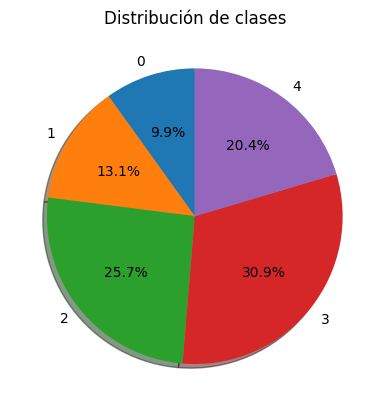

In [8]:
fig1, ax1 = plt.subplots()
plt.title("Distribución de clases")
ax1.pie(count, labels=clases, autopct='%1.1f%%',
        shadow=True, startangle=90)

plt.show()

En este gráfico, se puede observar como las clases generales (mamífero, anfibio, etc) no están balanceadas. Teniendo pocos datos de tipo anfibio y muchos de mamíferos

In [16]:
Ytodos = [Y_Ave, Y_mamifero, Y_Anfibio, Y_Antropodo, Y_Reptil]
Label = ["Ave", "Mamifero", "Anfibio", "Antropodo", "Reptil"]
AllCounts = []
AllClases = []
for y_i in Ytodos:
    clases=[]
    count=[]
    for cls, n in zip(*np.unique(y_i, return_counts=True)):
        clases.append(cls)
        count.append((n/float(len(Y)))*100)
    AllCounts.append(count)
    AllClases.append(clases)

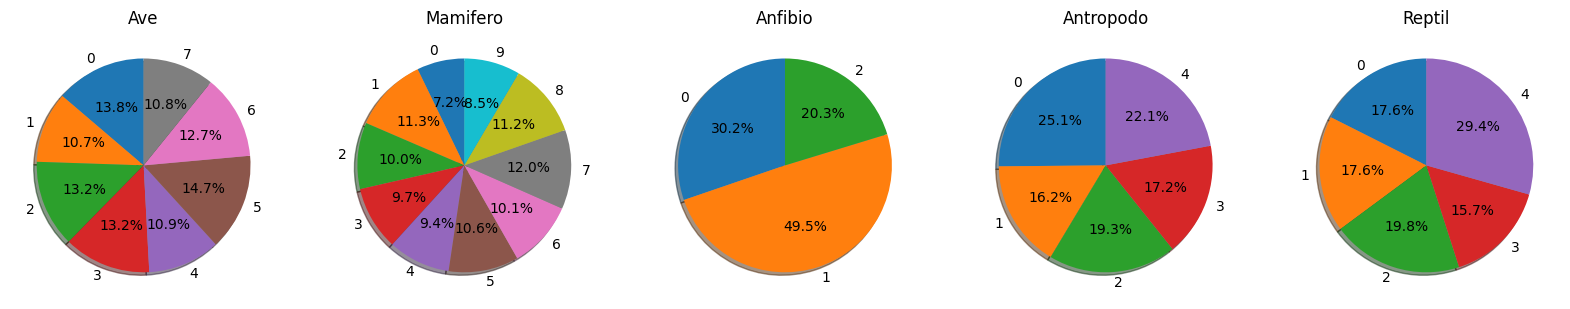

In [17]:
fig, ax = plt.subplots(1, 5, figsize=(20,4),)
for i in range(5):
    ax[i].set_title(Label[i])
    ax[i].pie(AllCounts[i], labels=AllClases[i], autopct='%1.1f%%',
            shadow=True, startangle=90)

plt.show()

### Estandarizacion de los datos
En esta sección usamos los recursos entregados en la tarea guiada para estandarizar los valores de cada uno de los dataset para cada red.

#### General

Encoder

In [88]:
# Creating instance of labelencoder
le = LabelEncoder()

# Fit the transformer
le.fit(Y)
y_le = le.transform(Y)

# Creating instance of onehotencoder
ohe = OneHotEncoder(handle_unknown='ignore')

ohe.fit(y_le.reshape(-1, 1))
y_ohe= ohe.transform(y_le.reshape(-1, 1)).toarray()

Separar data

In [89]:
sf = StratifiedShuffleSplit(n_splits=1,test_size=0.1, train_size=0.9, random_state=42)
for train_index, val_index in sf.split(X, y_ohe):
    X_train, X_test = X[train_index], X[val_index]
    y_train, y_test = y_ohe[train_index], y_ohe[val_index]  

In [90]:
sf2 = StratifiedShuffleSplit(n_splits=1, test_size=2/9, random_state=42)

for train_index, test_index in sf2.split(X_train, y_train):
    X_train, X_val = X_train[train_index], X_train[test_index]
    y_train, y_val = y_train[train_index], y_train[test_index]  

Normalización

In [91]:
# Perform Standarization
def prep_normalize(X_train, X_val, X_test):	
		
		x_means = X_train.mean(axis=(0,1,2), keepdims=True)
		x_std = X_train.std(axis=(0,1,2), keepdims=True)
		
		X_train	= ((X_train - x_means) / x_std).astype(np.float32)
		X_val   = ((X_val - x_means) / x_std).astype(np.float32)
		X_test  = ((X_test - x_means) / x_std).astype(np.float32)

		# Standarize each channel separately.
		return X_train, X_val, X_test
X_train, X_val, X_test = prep_normalize(X_train, X_val, X_test)

#### Anfibio

Encoder

In [92]:
# Creating instance of labelencoder
le = LabelEncoder()

# Fit the transformer
le.fit(Y_Anfibio)
y_le_anf = le.transform(Y_Anfibio)

# Creating instance of onehotencoder
ohe = OneHotEncoder(handle_unknown='ignore')

ohe.fit(y_le_anf.reshape(-1, 1))
y_ohe_anf= ohe.transform(y_le_anf.reshape(-1, 1)).toarray()

Separar data

In [93]:
sf = StratifiedShuffleSplit(n_splits=1,test_size=0.1, train_size=0.9, random_state=42)
for train_index, val_index in sf.split(X_Anfibio, y_ohe_anf):
    X_trAnf, X_testAnf = X_Anfibio[train_index], X_Anfibio[val_index]
    y_trAnf, y_testAnf = y_ohe_anf[train_index], y_ohe_anf[val_index]  

In [94]:
sf2 = StratifiedShuffleSplit(n_splits=1, test_size=2/9, random_state=42)

for train_index, test_index in sf2.split(X_trAnf, y_trAnf):
    X_trAnf, X_valAnf = X_trAnf[train_index], X_trAnf[test_index]
    y_trAnf, y_valAnf = y_trAnf[train_index], y_trAnf[test_index]  

Normalización

In [95]:
# Perform Standarization
def prep_normalize(X_train, X_val, X_test):	
		
		x_means = X_train.mean(axis=(0,1,2), keepdims=True)
		x_std = X_train.std(axis=(0,1,2), keepdims=True)
		
		X_train	= ((X_train - x_means) / x_std).astype(np.float32)
		X_val   = ((X_val - x_means) / x_std).astype(np.float32)
		X_test  = ((X_test - x_means) / x_std).astype(np.float32)

		# Standarize each channel separately.
		return X_train, X_val, X_test
X_trAnf, X_valAnf, X_testAnf = prep_normalize(X_trAnf, X_valAnf, X_testAnf)

#### Antropodo

Encoder

In [96]:
# Creating instance of labelencoder
le = LabelEncoder()

# Fit the transformer
le.fit(Y_Antropodo)
y_le_ant = le.transform(Y_Antropodo)

# Creating instance of onehotencoder
ohe = OneHotEncoder(handle_unknown='ignore')

ohe.fit(y_le_ant.reshape(-1, 1))
y_ohe_ant= ohe.transform(y_le_ant.reshape(-1, 1)).toarray()

Separar data

In [97]:
sf = StratifiedShuffleSplit(n_splits=1,test_size=0.1, train_size=0.9, random_state=42)
for train_index, val_index in sf.split(X_Antropodo, y_ohe_ant):
    X_trAnt, X_testAnt = X_Antropodo[train_index], X_Antropodo[val_index]
    y_trAnt, y_testAnt = y_ohe_ant[train_index], y_ohe_ant[val_index]  

In [98]:
sf2 = StratifiedShuffleSplit(n_splits=1, test_size=2/9, random_state=42)

for train_index, test_index in sf2.split(X_trAnt, y_trAnt):
    X_trAnt, X_valAnt = X_trAnt[train_index], X_trAnt[test_index]
    y_trAnt, y_valAnt = y_trAnt[train_index], y_trAnt[test_index]  

Normalización

In [99]:
# Perform Standarization
def prep_normalize(X_train, X_val, X_test):	
		
		x_means = X_train.mean(axis=(0,1,2), keepdims=True)
		x_std = X_train.std(axis=(0,1,2), keepdims=True)
		
		X_train	= ((X_train - x_means) / x_std).astype(np.float32)
		X_val   = ((X_val - x_means) / x_std).astype(np.float32)
		X_test  = ((X_test - x_means) / x_std).astype(np.float32)

		# Standarize each channel separately.
		return X_train, X_val, X_test
X_trAnt, X_valAnt, X_testAnt = prep_normalize(X_trAnt, X_valAnt, X_testAnt)

#### Ave

Encoder

In [100]:
# Creating instance of labelencoder
le = LabelEncoder()

# Fit the transformer
le.fit(Y_Ave)
y_le_ave = le.transform(Y_Ave)

# Creating instance of onehotencoder
ohe = OneHotEncoder(handle_unknown='ignore')

ohe.fit(y_le_ave.reshape(-1, 1))
y_ohe_ave= ohe.transform(y_le_ave.reshape(-1, 1)).toarray()

Separar data

In [101]:
sf = StratifiedShuffleSplit(n_splits=1,test_size=0.1, train_size=0.9, random_state=42)
for train_index, val_index in sf.split(X_Ave, y_ohe_ave):
    X_trAve, X_testAve = X_Ave[train_index], X_Ave[val_index]
    y_trAve, y_testAve = y_ohe_ave[train_index], y_ohe_ave[val_index]  

In [102]:
sf2 = StratifiedShuffleSplit(n_splits=1, test_size=2/9, random_state=42)

for train_index, test_index in sf2.split(X_trAve, y_trAve):
    X_trAve, X_valAve = X_trAve[train_index], X_trAve[test_index]
    y_trAve, y_valAve = y_trAve[train_index], y_trAve[test_index]  

Normalización

In [103]:
# Perform Standarization
def prep_normalize(X_train, X_val, X_test):	
		
		x_means = X_train.mean(axis=(0,1,2), keepdims=True)
		x_std = X_train.std(axis=(0,1,2), keepdims=True)
		
		X_train	= ((X_train - x_means) / x_std).astype(np.float32)
		X_val   = ((X_val - x_means) / x_std).astype(np.float32)
		X_test  = ((X_test - x_means) / x_std).astype(np.float32)

		# Standarize each channel separately.
		return X_train, X_val, X_test
X_trAve, X_valAve, X_testAve = prep_normalize(X_trAve, X_valAve, X_testAve)

#### Mamífero

Encoder

In [104]:
# Creating instance of labelencoder
le = LabelEncoder()

# Fit the transformer
le.fit(Y_mamifero)
y_le_mam = le.transform(Y_mamifero)

# Creating instance of onehotencoder
ohe = OneHotEncoder(handle_unknown='ignore')

ohe.fit(y_le_mam.reshape(-1, 1))
y_ohe_mam= ohe.transform(y_le_mam.reshape(-1, 1)).toarray()

Separar data

In [105]:
sf = StratifiedShuffleSplit(n_splits=1,test_size=0.1, train_size=0.9, random_state=42)
for train_index, val_index in sf.split(X_mamifero, y_ohe_mam):
    X_trMam, X_testMam = X_mamifero[train_index], X_mamifero[val_index]
    y_trMam, y_testMam = y_ohe_mam[train_index], y_ohe_mam[val_index]  

In [106]:
sf2 = StratifiedShuffleSplit(n_splits=1, test_size=2/9, random_state=42)

for train_index, test_index in sf2.split(X_trAnf, y_trAnf):
    X_trMam, X_valMam = X_trMam[train_index], X_trMam[test_index]
    y_trMam, y_valMam = y_trMam[train_index], y_trMam[test_index]  

Normalización

In [107]:
# Perform Standarization
def prep_normalize(X_train, X_val, X_test):	
		
		x_means = X_train.mean(axis=(0,1,2), keepdims=True)
		x_std = X_train.std(axis=(0,1,2), keepdims=True)
		
		X_train	= ((X_train - x_means) / x_std).astype(np.float32)
		X_val   = ((X_val - x_means) / x_std).astype(np.float32)
		X_test  = ((X_test - x_means) / x_std).astype(np.float32)

		# Standarize each channel separately.
		return X_train, X_val, X_test
X_trMam,  X_valMam, X_testMam = prep_normalize(X_trMam,  X_valMam, X_testMam )

#### Reptil

Encoder

In [108]:
# Creating instance of labelencoder
le = LabelEncoder()

# Fit the transformer
le.fit(Y_Reptil)
y_le_rep = le.transform(Y_Reptil)

# Creating instance of onehotencoder
ohe = OneHotEncoder(handle_unknown='ignore')

ohe.fit(y_le_rep.reshape(-1, 1))
y_ohe_rep= ohe.transform(y_le_rep.reshape(-1, 1)).toarray()

Separar data

In [109]:
sf = StratifiedShuffleSplit(n_splits=1,test_size=0.1, train_size=0.9, random_state=42)
for train_index, val_index in sf.split(X_Anfibio, y_ohe_anf):
    X_trRep, X_testRep = X_Reptil[train_index], X_Reptil[val_index]
    y_trRep, y_testRep = y_ohe_rep[train_index], y_ohe_rep[val_index]  

In [110]:
sf2 = StratifiedShuffleSplit(n_splits=1, test_size=2/9, random_state=42)

for train_index, test_index in sf2.split(X_trAnf, y_trAnf):
    X_trRep, X_valRep= X_trRep[train_index], X_trRep[test_index]
    y_trRep, y_valRep = y_trRep[train_index], y_trRep[test_index]  

Normalización

In [111]:
# Perform Standarization
def prep_normalize(X_train, X_val, X_test):	
		
		x_means = X_train.mean(axis=(0,1,2), keepdims=True)
		x_std = X_train.std(axis=(0,1,2), keepdims=True)
		
		X_train	= ((X_train - x_means) / x_std).astype(np.float32)
		X_val   = ((X_val - x_means) / x_std).astype(np.float32)
		X_test  = ((X_test - x_means) / x_std).astype(np.float32)

		# Standarize each channel separately.
		return X_train, X_val, X_test
X_trRep, X_valRep, X_testRep = prep_normalize(X_trRep, X_valRep, X_testRep)

### Entrenamiento de modelos

Para el modelo se considera en primera un transfer learning utilizando ''MobileNetV2'' y luego aplicar dos capas densas. Además, para el entrenamiento se considera data data augmentation para reducir el overfitting.

In [112]:
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2

title =  ["Anfibios", "Antropodos", "Ave", "Mamífero", "Reptil", "General"]
lista= [[X_trAnf, X_valAnf, X_testAnf, y_trAnf, y_valAnf, y_testAnf],
        [X_trAnt, X_valAnt, X_testAnt, y_trAnt, y_valAnt, y_testAnt], 
        [X_trAve, X_valAve, X_testAve, y_trAve, y_valAve, y_testAve], 
        [X_trMam, X_valMam, X_testMam, y_trMam, y_valMam, y_testMam], 
        [X_trRep, X_valRep, X_testRep, y_trRep, y_valRep, y_testRep], 
        [X_train, X_val, X_test, y_train, y_val, y_test]]

historia_o=list()

for j,i in enumerate(lista):
    datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=50,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range =0.0, # Randomly zoom image 
        width_shift_range=0.0,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.0,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False)  # randomly flip images

    datagen.fit(i[0])
    inputs = Input(shape=i[0].shape[1:])
    num_classes = len(i[3][0])
    e=20
    bs=64

    model = Sequential()
    model.add(MobileNetV2(include_top = False, weights="imagenet", input_shape=(150, 150, 3)))
    model.add(tf.keras.layers.GlobalAveragePooling2D())
    model.add(Dense(128, activation = 'relu'))
    model.add(Dense(num_classes, activation='softmax'))
    model.layers[0].trainable = False

    model.compile(optimizer="adam", loss ='categorical_crossentropy', metrics = 'accuracy')
    my_callbacks = [History(), EarlyStopping(patience=10, min_delta=0.01, monitor='val_accuracy', mode="max",restore_best_weights = True)]
    #Fit the model
    history = model.fit(datagen.flow(i[0], i[3]), validation_data=datagen.flow(i[2], i[5]), epochs=e, batch_size=bs) #Epcoh y batch size
    historia_o.append(history)
    model.save('Modelos/'+title[j]+'.h5')

Epoch 1/20
7/7 [==============================] - 30s 2s/step - loss: 1.5735 - accuracy: 0.5051 - val_loss: 1.5332 - val_accuracy: 0.5172
Epoch 2/20
7/7 [==============================] - 7s 972ms/step - loss: 0.5564 - accuracy: 0.7500 - val_loss: 0.4885 - val_accuracy: 0.7586
Epoch 3/20
7/7 [==============================] - 7s 990ms/step - loss: 0.3702 - accuracy: 0.8418 - val_loss: 0.5198 - val_accuracy: 0.8276
Epoch 4/20
7/7 [==============================] - 7s 939ms/step - loss: 0.2528 - accuracy: 0.9184 - val_loss: 0.2102 - val_accuracy: 0.8966
Epoch 5/20
7/7 [==============================] - 7s 910ms/step - loss: 0.1943 - accuracy: 0.9286 - val_loss: 0.2628 - val_accuracy: 0.9310
Epoch 6/20
7/7 [==============================] - 7s 955ms/step - loss: 0.1554 - accuracy: 0.9439 - val_loss: 0.4261 - val_accuracy: 0.8276
Epoch 7/20
7/7 [==============================] - 7s 945ms/step - loss: 0.1672 - accuracy: 0.9592 - val_loss: 0.3095 - val_accuracy: 0.8621
Epoch 8/20
7/7 [======

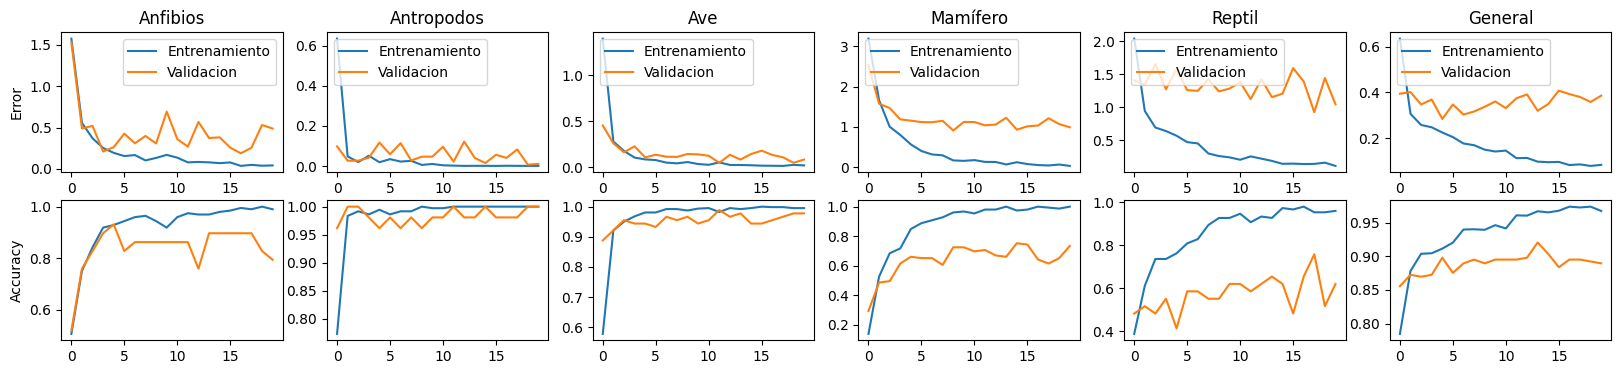

In [113]:
title =  ["Anfibios", "Antropodos", "Ave", "Mamífero", "Reptil", "General"]


fig, ax = plt.subplots(2, 6, figsize=(20,4),)


for i in range(6):
    ax[0,i].plot(range(e), historia_o[i].history['loss'])
    ax[0,i].plot(range(e), historia_o[i].history['val_loss'])
    ax[1,i].plot(range(e), historia_o[i].history['accuracy'], label ="Training accuracy" )
    ax[1,i].plot(range(e), historia_o[i].history['val_accuracy'], label ="Validation accuracy" )
    ax[0,i].legend(['Entrenamiento', 'Validacion'], loc='upper left')
    ax[0,i].set_title(str(title[i]))
    ax[0,i].set_xlabel("epoch")
  
ax[0,0].legend(['Entrenamiento', 'Validacion'], loc='upper right')

ax[0,0].set_ylabel('Error')
ax[1,0].set_ylabel('Accuracy')
plt.show()

En la gráfica anterior se puede ver el rendimiento de cada red, donde la red asociada a mamíferos y reptiles son las que presentan un peor rendimiento, el cual puede ser causado por un overfitting (ya que el loss no disminuye en el dataset de validación)

### Predicciones

Con las redes entrenadas se procede a generar las predicciones sobre el conjunto de prueba entregado.

In [114]:
def chooseMax(arr):
    index = 0
    val = 0.0
    for i, v in enumerate(arr):
        if v>val:
            index = i
            val = v
    return index

Y_final = []
dataset_final = pd.read_csv("Test.csv")
modelGeneral = keras.models.load_model('Modelos/General.h5')
modelAntropodo = keras.models.load_model('Modelos/Antropodos.h5')
modelAmfibio = keras.models.load_model('Modelos/Anfibios.h5')
modelMamifero = keras.models.load_model('Modelos/Mamífero.h5')
modelAve = keras.models.load_model('Modelos/Ave.h5')
modelReptil = keras.models.load_model('Modelos/Reptil.h5')

n =  150
for i,idFile in enumerate(dataset_final["Id"].values):
    img= Image.open("Test/"+idFile)
    img.thumbnail((n,n), Image.Resampling.LANCZOS)
    np_img = np.array(img)

    aux = [ [np.array([0,0,0]) for i in range(n)] for j in range(n)]
    for k in range(np_img.shape[0]):
        for j in range(np_img.shape[1]):
            if type(np_img[k,j]) != np.ndarray:
                aux[k][j] = [0,np_img[k,j],0]
            else:
                aux[k][j] = np_img[k,j][:3]
    np_img = np.array(aux)

    auxPre = modelGeneral.predict(np.array([np_img]))
    FirstClass = chooseMax(auxPre[0])

    val = 0
    if FirstClass == 0:
        pre = modelAntropodo.predict( np.array([np_img]) )
        val = chooseMax(pre[0]) +6
    if FirstClass == 1:
        pre = modelAmfibio.predict( np.array([np_img]) )
        val = chooseMax(pre[0]) +9
    if FirstClass == 2:
        pre = modelMamifero.predict( np.array([np_img]) )
        val = chooseMax(pre[0]) +14
    if FirstClass == 3:
        pre = modelAve.predict( np.array([np_img]) )
        val = chooseMax(pre[0]) +22
    if FirstClass == 4:
        pre = modelReptil.predict( np.array([np_img]) )
        val = chooseMax(pre[0]) +32
    Y_final.append( str(FirstClass) + " " + str(val) )

1/1 [==============================] - 0s 180ms/step


In [115]:
d = dataset_final["Id"].values
dt = pd.DataFrame( {"Expected":Y_final}, index=d )
dt.to_csv('final.csv')